# CAPSTONE PROJECT: CAN THE COMPUTERS READ IT TOO?

# 1: DATA PREPARATION

## 1.1 Setting up the notebook

In [2]:
import io
import os
import glob
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import boto3
import sagemaker
from sagemaker import get_execution_role

%matplotlib inline

In [3]:
cache_dir = 'cache' # The folder we will use for storing data
data_dir = os.path.join(cache_dir, 'data')
model_dir = os.path.join(cache_dir, 'model')

import pickle

During this notebook you will find some clean cells to clean variables in order to have the maximum space available while processing the notebook.

## 1.2 Downloading the data

First we will download the data.

In [3]:
if 'blogger.zip' not in os.listdir('.'):
    !wget -O blogger.zip http://www.cs.biu.ac.il/~koppel/blogs/blogs.zip
else:
    print('zip already downloaded')
!unzip -Z1 blogger.zip | head -1500 | sed 's| |\\ |g' | xargs unzip blogger.zip
print('zip unziped')


zip already downloaded
Archive:  blogger.zip
replace blogs/1000331.female.37.indUnk.Leo.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)
zip unziped


In [4]:
# print(len([name for name in os.listdir('blogs') if os.path.isfile(name)]))
print(len(os.listdir('blogs/')))

1499


As it was pretty big (total of 19320 blogs) with maybe too much files (considering that inside each blog normally there is more than one post) so only a subset of it was unzipped. The subset selected is on the head part of the command, in this case resulted in 1499 blogs.

## 1.3 Preparing the data

In [ ]:
path = os.path.join('blogs', '*.xml')
files = glob.glob(path)

with open(files[0], encoding='Windows-1252') as f:
    print(f.read())

As we can observe, each blog consists of different posts, which we will separate, as we are only interested in posts, and we don't want the dates or other info that could be inside the XML's files.

As XML files they consist of different tags. We are only gonna take the **post** ones.
    
We used the Beautiful soup to get the texts, that because with other parsers like ElementTree it resulted in ParseError in some files, as there are some HTML elements (like &nspb).

In [4]:
from bs4 import BeautifulSoup

def read_blogs_data(data_dir='blogs'):
    data = []

    path = os.path.join(data_dir, '*.xml')
    files = glob.glob(path)

    for f in files:
        blog = open(f)

        soup = BeautifulSoup(blog, 'xml')
        posts = soup.find_all('post')

        for post in posts:
            data.append(post.text)
    return data

blogs_data = read_blogs_data()


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x92 in position 119205: invalid start byte

It appears that there is some error, something related to the decoding.
After searching for some time we find a possible solution to which type are the files encoded.

In [5]:
import chardet

blog_dir = os.path.join('blogs', os.listdir('blogs')[0])
blog = open(blog_dir, 'rb')
enco = chardet.detect(blog.read())['encoding']
print(enco)

utf-8


So we use this encoding into the parsing of all the files.

In [6]:
def read_blogs_data(data_dir='blogs', encod = "ISO-8859-1" ):
    data = []

    path = os.path.join(data_dir, '*.xml')
    files = glob.glob(path)

    for f in files:
        blog = open(f, encoding=encod)

        soup = BeautifulSoup(blog, 'xml')
        posts = soup.find_all('post')

        for post in posts:
            data.append(post.text)

    return data

In [7]:
blogs_data = read_blogs_data()

In [8]:
#number of posts
print("# of posts = {}".format(len(blogs_data)))

# of posts = 176796


In [9]:
#check them
print('post50: ', blogs_data[50])

post50:  

						
						    urlLink Billmon  has a nice  urlLink takedown  of Barone's  urlLink latest column .  Man that guy rubs me the wrong way.   The best evidence last week's Democratic convention succeeded in accomplishing what Team Kerry set out to do is the Republican reaction, which is to insist the Boston infomercial was a false representation of both the party and the nominee.   To a certain extent, that's true - although as a progressive, I would argue it's not nearly as true as the conservative chattering class would have it. No matter how left-wing the delegates on the floor were on the hot-button issues (this was almost an hourly talking point on Fox and CNN) the face of the party establishment was pretty much the face we saw on the stage - culturally liberal on social issues, Clintonian centrists on economics, but most of all, completely pragmatic about elections and what it takes to win them.  This last quality, of course, is one the Mayberry Machiavellis also share. 

Now we have the data parsed, which consists of 176.796 posts from the 1499 blogs used.

## 1.4 Processing the Data

Now we have all the posts text in the 'blogs_data' array, so we will apply to it the processing.

- To start, we shuffle all the posts.

In [10]:
from sklearn.utils import shuffle

blogs_data_shuffled = shuffle(blogs_data)
print('post50 shuffled: ', blogs_data_shuffled[50])

post50 shuffled:  

	 
      . virtues and vices .  the new blogger user interface asked me if, because i push snooze on my alarm clock, i was lazy. nope. i typed.  just tired.   and if i were to go into it -- i'd go so far as to say that its much more of a symbol of my ambition in tension with my finitude.    it is my ambition that drives me to set my alarm clock to 5 or 5:30 every morning -- mostly so i can have writing time.  it is my exhaustion that often motivates me to take a few minutes of rest before i attack the day.   so laziness isn't my vice -- nor is ambition my virtue.   i'm quite confident, though that *distraction* is my vice -- is well roundedness the accompanying virtue?   ambition + distraction is the equivalent of a driverless vehicle careening forward on a full tank of gas.   peace~
    



Then we apply different processing steps:
    - remove the \n, \t, whitespaces starting and ending
    - remove possible HTML tags and other
    - put all in lowercase
    - remove accents in some chars
    - separate the posts by words with the help of the indices
    - get the words array from the indices
    - ignore words that have chars not considered integers, letters nor punctuation
    - also ignore words which are only integers or punctuation
    - limit the posts to 500 words per posts (sentence)
    - we ignore the words larger than supercalifragilisticexpialidocious
    
So finally, a list of words are returned. These words include punctuation, which will have to take into account later.

In [11]:
print(len('supercalifragilisticexpialidocious'))

34


In [12]:
from itertools import groupby
import unicodedata
import string

def splitWithIndices(s, c=' '):
    p = 0
    for k, g in groupby(s, lambda x:x==c):
        q = p + sum(1 for i in g)
        if not k:
            yield p, q # or p, q-1 if you are really sure you want that
        p = q

def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')


def post_to_words(post):
    LIMIT_WORDS = 500

    post = post.lstrip().rstrip()
    post = BeautifulSoup(post, "html.parser").get_text()
    post = post.lower()
    
    words_accents = []
    for word in post:
        words_accents.append(strip_accents(word))
        
    words_ind = splitWithIndices(words_accents)
        
    words_aux = []
    for idx in words_ind:
        words_aux.append(post[idx[0]:idx[1]])
    
    words = []
    for idx, word in enumerate(words_aux):
        isvalid = True
        isdigit = True
        ispunct = True

        for letter in word:
            if not letter.isdigit():
                if letter not in string.punctuation:
                    if not letter.isalpha():
                        isvalid = False
            
            if not letter.isdigit():
                isdigit = False
            if letter not in string.punctuation:
                ispunct = False
                
        if isvalid == True and isdigit == False and ispunct == False:
            if len(word) <= len('supercalifragilisticexpialidocious') and idx <= LIMIT_WORDS:
                words.append(word)
        
    return words


In [13]:
# Check it
words = post_to_words(blogs_data_shuffled[60])
print(blogs_data_shuffled[60])
print(words)

word1 = '123456 .,'
w1 = post_to_words(word1)
print('\n{} -> {}'.format(word1, w1))



	 
       UK - Do not blame Indiia for JOb Loss  Atleast somebody is thinking sensibly. It is also very important at these times that India (NASSCOM  GOvt.) does some brand building and PR to spread some goodwill and erase the 'anti-outsourcing-anti-india' sentiments.::  Asking Britain's trade unions to show a sense of fairness towards India, British Deputy Prime Minister John Prescott has said that it was "unfair" to blame India for loss of British jobs because of "outsourcing" and India must be gi ven a chance to develop its skills and markets.... [Source :  urlLink The Hindu ] 
     
    

['uk', 'do', 'not', 'blame', 'indiia', 'for', 'job', 'loss', 'atleast', 'somebody', 'is', 'thinking', 'sensibly.', 'it', 'is', 'also', 'very', 'important', 'at', 'these', 'times', 'that', 'india', '(nasscom', 'govt.)', 'does', 'some', 'brand', 'building', 'and', 'pr', 'to', 'spread', 'some', 'goodwill', 'and', 'erase', 'the', "'anti-outsourcing-anti-india'", 'sentiments.::', 'asking', "britain's

Instead of having the data as sentences, we will have it as words, as the input of the model will be word by word.

The method below applies the post_to_words method for all the sentences in the dataset indicated. In addition, it caches the results. This is because performing this processing step can take a long time. This way if you are unable to complete the notebook in the current session, you can come back without needing to process the data a second time.

We ignore the sentences which for whenever reason have length 0, meaning all the words has been ignored (following the rules stated in the post2words) and ignore the words with length less than 4 letters, as they will not add anything to the model once jumbled.

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

def preprocess_blogs(data, cache_dir, cache_file="preprocessed_blogs2.pkl"):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()

    # If cache_file is not None, try to read from it first
    file_dir = os.path.join(cache_dir, cache_file)

    cache_data = None
    if cache_file is not None:
        try:
            with open(file_dir, "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", file_dir)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_data = []
        perc = 0
        
        for idx_p, post in enumerate(data):
            
            if idx_p / len(data) >= perc:
                print('{} / {} sentences = {}%'.format(idx_p, len(data), np.round(perc*100, decimals = 1)))
                perc = perc+0.1
            
            words = post_to_words(post)
            words_stemmed = [PorterStemmer().stem(w) for w in words] # stem
            
            words_len = [word for word in words if len(word) > 3] #ignore words with less than 4 letters
            if len(words_len) != 0:
                words_data += words_len
                        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_data=words_data)
            with open(file_dir, "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", file_dir)
    else:
        # Unpack data loaded from cache file
        words_data = (cache_data['words_data'])
    
    return words_data


In [15]:
# Process all the blogs
if not os.path.exists(cache_dir): # Make sure that the folder exists, if not create it
    os.makedirs(cache_dir)

words_data = preprocess_blogs(blogs_data_shuffled, cache_dir)
print('The dataset consists of {} words'.format(len(words_data)))

Read preprocessed data from cache file: cache/preprocessed_blogs2.pkl
The dataset consists of 16634430 words


We have more than 16 milion words in 176.796 sentences. Remember that only a subset of 1499 blogs out of 13.000 were used, imagine if all the blogs were used!

In [17]:
# check the length of number of letters per word is adecuated
maxlen_w = 0
minlen_w = 1000

for word in words_data:
    if len(word) > maxlen_w:
        maxlen_w = len(word)
    if len(word) < minlen_w:
        minlen_w = len(word)

mean_w = np.mean([len(w) for w in words_data])

print('max length word: {}'.format(maxlen_w))
print('min length word: {}'.format(minlen_w))
print('mean length word: {}'.format(mean_w))

max length word: 34
min length word: 4
mean length word: 5.903403002086636


We will create a dictionary from the words processed and from it we will extract the most common 5.000 words.

In [18]:
def dict_from_data(data, vocab_size = 10000):    
    word_count = {} # A dict storing the words that appear in the reviews along with how often they occur

    for word in data:
        if word in word_count:
            word_count[word]+=1
        else:
            word_count[word]=1
            
    print('Length of the dictionary: {}'.format(len(word_count)))
    
    sorted_words = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
    sorted_words = [tupl[0] for tupl in sorted_words]

    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size]): # The -2 is so that we save room for the 'no word'
        word_dict[word] = idx                           # 'infrequent' labels
        
    return word_dict

### Training and test datasets

From here we will have separated the training and test datasets. The training will consist of the 5000 words more common in the blogs read. On the other hand, the test will consist of 1000 words randomly selected within the blogs. 

In [19]:
word_dict = dict_from_data(words_data)
print(word_dict)
train_data = [key for key in word_dict.keys()]
print(train_data[:5])

Length of the dictionary: 810981
{'that': 0, 'have': 1, 'with': 2, 'this': 3, 'just': 4, 'like': 5, 'about': 6, 'urllink': 7, 'they': 8, 'from': 9, 'what': 10, "it's": 11, 'when': 12, 'will': 13, 'some': 14, 'really': 15, 'your': 16, "don't": 17, 'there': 18, 'know': 19, 'then': 20, 'think': 21, 'would': 22, 'been': 23, 'more': 24, 'going': 25, 'time': 26, 'were': 27, 'good': 28, 'because': 29, 'people': 30, 'back': 31, 'only': 32, 'last': 33, 'want': 34, 'much': 35, 'which': 36, 'their': 37, 'even': 38, 'went': 39, 'after': 40, 'into': 41, "i've": 42, 'other': 43, 'very': 44, 'could': 45, 'over': 46, 'them': 47, 'still': 48, 'than': 49, 'make': 50, 'little': 51, 'love': 52, 'things': 53, 'first': 54, 'something': 55, 'never': 56, 'being': 57, 'feel': 58, 'well': 59, 'should': 60, "i'll": 61, 'here': 62, 'where': 63, 'need': 64, 'right': 65, 'also': 66, "didn't": 67, 'work': 68, "can't": 69, 'take': 70, 'around': 71, "that's": 72, 'down': 73, 'those': 74, 'most': 75, 'thing': 76, 'toda

We are gonna look a little how our words are distributed:

Mean length word of the vocabulary: 6.5097


[Text(0, 0.5, 'count words'),
 Text(0.5, 0, '# letters per word'),
 Text(0.5, 1.0, 'Dictionary Histogram')]

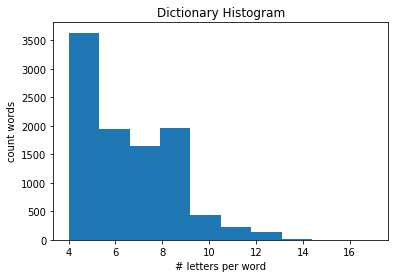

In [20]:
lengths_vocab = [len(w) for w in train_data]
mean_vocab = np.mean(lengths_vocab)
print('Mean length word of the vocabulary: {}'.format(mean_vocab))

plt.hist(lengths_vocab)
plt.gca().set(title='Dictionary Histogram', ylabel='count words', xlabel='# letters per word')

This graph contrast with the distribution of the length on the english words, which have a mean of 8.23 characters (as commented in http://www.ravi.io/language-word-lengths). But we have to take into acount that we didn’t take as sample all the english dictionary, as the distribution of the english words lengths doesn’t take into account the frequency, which is normally higher for shorter words, being more easily represented in smaller samples.

Now we are gonna take a quick peek at the letter distributions:

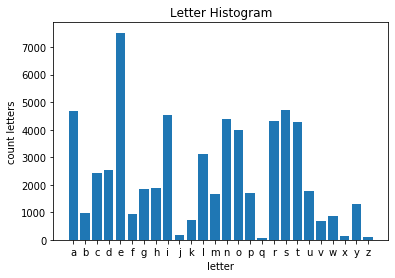

In [21]:
count = []
values = []

for letter in string.ascii_lowercase:
    sum_letter = 0
    for word in train_data:
        sum_letter += word.count(letter)
    
    count.append(sum_letter)
    values.append(letter)
    
plt.bar(values, count)
plt.gca().set(title='Letter Histogram', ylabel='count letters', xlabel='letter');

This distribution is almost identical as the distribution of the letters in the english vocabulary!

In [22]:
# Test dataset
import random
test_data = random.choices(words_data, k=20000)

We have checked that the dataset we are going to use consist of the 5000 most common words in the blogs.

## 1.4 The dictionary

For the model we are going to construct in this notebook we will construct a feature representation which consists in representing each letter of each word as an integer. We will be using the Latin alphabet as a dictionary between letters and integers.

In [23]:
letter2int = dict(zip(string.ascii_lowercase, range(1,27)))
int2letter = {v: k for k, v in letter2int.items()}

print(len(letter2int), letter2int, '\n')
print(len(int2letter), int2letter, '\n')

26 {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26} 

26 {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'} 



## 1.5 Transform the words

Now that we have our word dictionary which allows us to transform the letters appearing in the words into integers, it is time to make use of it and convert our posts words to their integer sequence representation. Since we will be using a recurrent neural network, it will be convenient if the length of each word is the same. To do this, we will use the previously defined max size (the length of the word supercalifragilisticexpialidocious) as the fixed size for our words and then pad short words with the category 'no letter' (which we will label 0) and truncate long words.

For now, the punctuations and numbers will be ignored, as it will simplify drastically the task. If there's enough time in the future, it could be possible to implement some kind of punctuation mark holder that allows to save the punctuation of the sentence and put them back after.

In [24]:
def word2integer(letter_dict, word, pad = 34):
    padding = 0 #we will pad with zeros
    word_padded = []
    length = len(word)
    
    #conversion
    for letter_index, letter in enumerate(word):
        if letter in letter_dict:
            if letter_dict[letter] >= 0:
                word_padded.append(letter_dict[letter])
        else:
            length -= 1
    
    #padding
    if len(word_padded) < pad:
        word_padded = (word_padded + pad * [padding])[:pad]
            
    return word_padded, length

def sentence2integer(letter_dict, data, pad = 34):   
    result = []
    lengths = []
    perc = 0        
    
    for idx_w, word in enumerate(data):
        
        if idx_w / len(data) >= perc:
            print('{} / {} word = {}%'.format(idx_w, len(data), np.round(perc*100, decimals = 1)))
            perc = perc+0.1
        
        converted_word, len_word = word2integer(letter_dict, word, pad)
        result.append(converted_word)
        lengths.append(len_word)
        
    return result, lengths

In [25]:
train_data_padded, train_data_padded_len = sentence2integer(letter2int, train_data)
test_data_p, len_test_p = sentence2integer(letter2int, test_data)

# There are some words in training that after the transformation will stay at less than 4 letters, so they will be disposed now.
train_data_p = [] 
len_train_p = []
for word, lenw in zip(train_data_padded, train_data_padded_len):
    if lenw > 3:
            train_data_p.append(word)
            len_train_p.append(lenw)
            
print('Previous lengths: {}-{} \nNew length: {}-{}'.format(len(train_data_padded), len(train_data_padded_len), 
                                                           len(train_data_p), len(len_train_p)))

0 / 10000 word = 0%
1000 / 10000 word = 10.0%
2000 / 10000 word = 20.0%
3001 / 10000 word = 30.0%
4000 / 10000 word = 40.0%
5000 / 10000 word = 50.0%
6000 / 10000 word = 60.0%
7000 / 10000 word = 70.0%
8000 / 10000 word = 80.0%
9000 / 10000 word = 90.0%
0 / 20000 word = 0%
2000 / 20000 word = 10.0%
4000 / 20000 word = 20.0%
6001 / 20000 word = 30.0%
8000 / 20000 word = 40.0%
10000 / 20000 word = 50.0%
12000 / 20000 word = 60.0%
14000 / 20000 word = 70.0%
16000 / 20000 word = 80.0%
18000 / 20000 word = 90.0%
Previous lengths: 10000-10000 
New length: 9445-9445


In [26]:
#Check
for ind_w in [2, 8]:
    print(train_data_p[ind_w], len_train_p[ind_w])

[23, 9, 20, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 4
[20, 8, 5, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 4


### Cleaning

In [27]:
files = None
blogs_data = None
blogs_data_shuffled = None
test_data = None
train_data = None
train_data_padded = None
train_data_padded_len = None
word = None
word1 = None
word_dict = None
words = None
words_data = None

## 1.6 Jumble the words

As the objective is to get back the words after being jumbled, we have now to jumble this data. We create a function to jumble the words, and then another function to handle all the words in a sentence.

Probabilistically, the result of the function could be the same word passed as input, but we will ignore this possible case. 

In [28]:
def jumble_word(word, word_len):
    if word_len <= 2:
        word_j = word
        
    else:
        sub_word = []
        for w in word:
            sub_word.append(w)

        sub_word = sub_word[1:word_len-1]
        shufled_word = shuffle(sub_word)
        
        word_j = word.copy()
        word_j[1:word_len-1] = shufled_word
        
    return word_j

In [29]:
# Check it
word = [1,2,3,4,5,6,7,0,0,0,0,0,0,0]
len_w = 7
print(jumble_word(word, len_w))

word = [1,2,0,0,0,0,0,0,0,0,0,0,0,0]
len_w = 2
print(jumble_word(word, len_w))

[1, 2, 5, 4, 6, 3, 7, 0, 0, 0, 0, 0, 0, 0]
[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [30]:
def jumble_data(data, data_len):
    jumbled_data = []
    
    idx_w = 0
    perc = 0
    for word, w_len in zip(data, data_len):
        jumbled_sentence = []

        if idx_w / len(data) >= perc:
            print('{} / {} words = {}%'.format(idx_w, len(data), np.round(perc*100, decimals = 1)))
            perc = perc+0.1

        jumbled_word = jumble_word(word, w_len)

        jumbled_data.append(jumbled_word)
        idx_w+=1
        
    return jumbled_data

In [31]:
jumbled_train = jumble_data(train_data_p, len_train_p)
jumbled_test = jumble_data(test_data_p, len_test_p)
print('Done')

0 / 9445 words = 0%
945 / 9445 words = 10.0%
1889 / 9445 words = 20.0%
2834 / 9445 words = 30.0%
3778 / 9445 words = 40.0%
4723 / 9445 words = 50.0%
5667 / 9445 words = 60.0%
6612 / 9445 words = 70.0%
7556 / 9445 words = 80.0%
8501 / 9445 words = 90.0%
0 / 20000 words = 0%
2000 / 20000 words = 10.0%
4000 / 20000 words = 20.0%
6001 / 20000 words = 30.0%
8000 / 20000 words = 40.0%
10000 / 20000 words = 50.0%
12000 / 20000 words = 60.0%
14000 / 20000 words = 70.0%
16000 / 20000 words = 80.0%
18000 / 20000 words = 90.0%
Done


In [32]:
#Check
for ind_w in [4, 6]:
    print('Word: {}'.format(train_data_p[ind_w]))
    print('Length: {}'.format(len_train_p[ind_w]))
    print('Jumbled: {}\n'.format(jumbled_train[ind_w]))
    
    print('Word: {}'.format(test_data_p[ind_w]))
    print('Length: {}'.format(len_test_p[ind_w]))
    print('Jumbled: {}\n'.format(jumbled_test[ind_w]))

Word: [10, 21, 19, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length: 4
Jumbled: [10, 21, 19, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Word: [1, 23, 1, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length: 4
Jumbled: [1, 1, 23, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Word: [1, 2, 15, 21, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length: 5
Jumbled: [1, 2, 21, 15, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Word: [20, 8, 5, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length: 4
Jumbled: [20, 8, 5, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



In [33]:
#Check sizes coincide
print('train input: {}, train output: {}, lengths train: {} \ntest input: {}, test output: {}, lengths test: {}'.format(
    len(jumbled_train), len(train_data_p), len(len_train_p),
    len(jumbled_test), len(test_data_p), len(len_test_p)))

# Check the same numbers are used in both input and output on same sentence number 
for word1, word2 in zip(jumbled_train, train_data_p):
    sum_num=0
    
    if len(word1) != len(word2):
        print('errror of size in training!')

    for indx in range(len(word1)):
        sum_num += word1[indx]-word2[indx]
    
    if sum_num != 0:
        print('error of numbers in training!')

for word1, word2 in zip(jumbled_test, test_data_p):
    sum_num=0
    
    if len(word1) != len(word2):
        print('errror of size in test!')

    for indx in range(len(word1)):
        sum_num += word1[indx]-word2[indx]
    
    if sum_num != 0:
        print('error of numbers in test!')
        
print('Done!')

train input: 9445, train output: 9445, lengths train: 9445 
test input: 20000, test output: 20000, lengths test: 20000
Done!


### 1.7.1 Uploading them

In [34]:
if not os.path.exists(data_dir): # Make sure that the folder exists, if not create it
    os.makedirs(data_dir)
    
# Uploading train and test files separately, we check it doesn't upload an empty file
data_files = [jumbled_train, train_data_p, len_train_p,
              jumbled_test, test_data_p, len_test_p]
cache_files = ['input_train_data.pkl', 'output_train_data.pkl', 'length_train_data.pkl',
               'input_test_data.pkl', 'output_test_data.pkl', 'length_test_data.pkl']

for data_file, cache_file in zip(data_files, cache_files):
    cache_data = None
    cache_data = dict(data_file=data_file)
    file_dir = os.path.join(data_dir, cache_file)

    with open(file_dir, "wb") as f:
        pickle.dump(cache_data, f)
        
    if os.path.getsize(file_dir) > 0:
        print("Wrote data to file:", file_dir)
    else:
        print('Wrote empty file on file', file_dir)
        
print('Done')    

Wrote data to file: cache/data/input_train_data.pkl
Wrote data to file: cache/data/output_train_data.pkl
Wrote data to file: cache/data/length_train_data.pkl
Wrote data to file: cache/data/input_test_data.pkl
Wrote data to file: cache/data/output_test_data.pkl
Wrote data to file: cache/data/length_test_data.pkl
Done


### Cleaning

In [35]:
# We are gonna clean some more variables as we will download them in the next sections or not gonna use them more
len_data_p = None
words_data_p = None
jumbled_data = None
trainX = None
trainY = None
train_len = None
testX = None
testY = None
test_len = None
word2 = None
word1 = None
word = None
data_file = None
data_files = None
files = None
cache_files = None

### 1.7.2 Loading them

In [36]:
def load_data(cache_file, data_dir=data_dir):
    cache_data = None
    file_dir = os.path.join(data_dir, cache_file)

    if os.path.getsize(file_dir) > 0:
        try:
            with open(file_dir, "rb") as f:
                cache_data = pickle.load(f)
            print("Read data from file:", file_dir)
        except:
            print('Problem reading the file', file_dir)
    else:
        print('File empty')

    if cache_data is None:
        print('Didnt read anything')
        resulting_files = []
    else:
        resulting_files = (cache_data['data_file'])
        
    return resulting_files

If you have already done all the previous steps in the past, you should have the training and test split files in the cache/data folder. We will load them and the dictionaries.

In [37]:
cache_files = ['input_train_data.pkl', 'input_test_data.pkl',
               'output_train_data.pkl', 'output_test_data.pkl',
               'length_train_data.pkl', 'length_test_data.pkl']

resulting_files = []
for cache_file in cache_files:
    resulting_files.append(load_data(cache_file, data_dir))
        
print('Done')

trainX, testX, trainY, testY, train_len, test_len = resulting_files

Read data from file: cache/data/input_train_data.pkl
Read data from file: cache/data/input_test_data.pkl
Read data from file: cache/data/output_train_data.pkl
Read data from file: cache/data/output_test_data.pkl
Read data from file: cache/data/length_train_data.pkl
Read data from file: cache/data/length_test_data.pkl
Done


In [38]:
# Check they have been loaded correctly
ind = 5

print('word trainX ->', trainX[ind])
print('word trainY ->', trainY[ind])
print('word train_len ->', str(train_len[ind]))

print('word testX ->', testX[ind])
print('word testY ->', testY[ind])
print('word test_len ->', str(test_len[ind]))

word trainX -> [12, 9, 11, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
word trainY -> [12, 9, 11, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
word train_len -> 4
word testX -> [20, 5, 18, 8, 5, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
word testY -> [20, 8, 5, 18, 5, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
word test_len -> 6


# 2 Upload data

## 2.1 Locally

We will need to upload the training dataset to S3 in order for our training code to access it. For now we will save both training and test locally and we will upload to S3 later on.

It is important to note the format of the data that we are saving as we will need to know it when we write the training code. In our case, each row of the dataset has the form output[34], length, input[34] where input[34] represents the word, which is a sequence of 34 integers the letters in the words.

We will save the training CSV and both dictionaries on the model directory, to upload later together in s3.

In [39]:
if not os.path.exists(model_dir): # Make sure that the folder exists if not, create it
    os.makedirs(model_dir)
    
pd.concat([pd.DataFrame(trainY), pd.DataFrame(train_len), pd.DataFrame(trainX)], axis=1) \
        .to_csv(os.path.join(model_dir, 'train.csv'), header=False, index=False)

pd.concat([pd.DataFrame(testY), pd.DataFrame(test_len), pd.DataFrame(testX)], axis=1) \
        .to_csv(os.path.join(cache_dir, 'test.csv'), header=False, index=False)

### Save the dictionaries

Later on, when we construct an endpoint which processes a submitted review we will need to make use of the dictionaries which we have created. As such, we will save them to a file now for future use.

In [40]:
with open(os.path.join(model_dir, 'letter2int_dict.pkl'), "wb") as f:
    pickle.dump(letter2int, f)
with open(os.path.join(model_dir, 'int2letter_dict.pkl'), "wb") as f:
    pickle.dump(int2letter, f)

If we wanted to load the dictionaries for any case from the files, it can be done using the next function.

In [41]:
def load_dictionary(dict_file, dict_dir = cache_dir):
    cache_data = None
    file_dir = os.path.join(dict_dir, dict_file)

    if os.path.getsize(file_dir) > 0:
        try:
            with open(file_dir, "rb") as f:
                cache_data = pickle.load(f)
            print("Read data from file:", dict_file)
        except:
            print('Problem reading file', dict_file)
    else:
        print('File empty')

    if cache_data is None:
        print('Didnt read anything')
    else:
        pass

    return cache_data

# For example
letter2int = load_dictionary('letter2int_dict.pkl', model_dir)
int2letter = load_dictionary('int2letter_dict.pkl', model_dir)

print(letter2int)
print(int2letter)

Read data from file: letter2int_dict.pkl
Read data from file: int2letter_dict.pkl
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


### Cleaning

In [42]:
trainX = None
testX = None
trainY = None
testY = None
train_len = None
test_len = None

## 2.2 To S3

Next, we need to upload the training data and the dictionaries to the SageMaker default S3 bucket so that we can provide access to it while training our model.

In [43]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/capstoneProject'

role = sagemaker.get_execution_role()

# upload training data to S3
train_dir = os.path.join(cache_dir, 'train.csv')
input_data = sagemaker_session.upload_data(path=model_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-us-east-2-670005714529/sagemaker/capstoneProject


Check that you've uploaded the data, by printing the contents of the default bucket.

In [44]:
# iterate through S3 objects and print contents
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
     print(obj.key)

sagemaker-pytorch-2020-08-10-10-25-18-500/source/sourcedir.tar.gz
sagemaker-pytorch-2020-08-10-10-49-25-390/sourcedir.tar.gz
sagemaker-pytorch-2020-08-10-11-43-00-806/sourcedir.tar.gz
sagemaker-pytorch-2020-08-10-12-29-45-086/sourcedir.tar.gz
sagemaker-pytorch-2020-08-10-12-42-16-743/source/sourcedir.tar.gz
sagemaker-pytorch-2020-08-10-12-56-05-270/source/sourcedir.tar.gz
sagemaker-pytorch-2020-08-10-13-45-49-644/source/sourcedir.tar.gz
sagemaker-pytorch-2020-08-10-15-05-41-149/source/sourcedir.tar.gz
sagemaker-pytorch-2020-08-10-15-51-51-449/sourcedir.tar.gz
sagemaker-pytorch-2020-08-10-17-02-14-291/source/sourcedir.tar.gz
sagemaker-pytorch-2020-08-10-17-23-07-386/source/sourcedir.tar.gz
sagemaker-pytorch-2020-08-10-17-39-38-750/source/sourcedir.tar.gz
sagemaker-pytorch-2020-08-10-18-11-25-123/source/sourcedir.tar.gz
sagemaker-pytorch-2020-08-10-18-33-23-479/source/sourcedir.tar.gz
sagemaker-pytorch-2020-08-10-18-50-06-663/source/sourcedir.tar.gz
sagemaker-pytorch-2020-08-10-19-26-54-

# 3. Train the Model

We will start by implementing our own neural network in PyTorch along with a training script. The necessary files for them are in the source folder, being them: train.py, model.py, predict.py and util.py.

## 3.1 Define the model

In [45]:
!pygmentize source/model.py

import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim):
        super(Encoder, self).__init__()
        self.hid_dim = hid_dim
        self.lstm = nn.LSTM(input_dim, hid_dim, batch_first = True)

    def forward(self, src):
        outputs, (hidden, cell) = self.lstm(src)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim):
        super(Decoder, self).__init__()
        self.hid_dim = hid_dim
        self.lstm = nn.LSTM(output_dim, hid_dim, batch_first = True)
        self.output_dim = output_dim
        self.fc = nn.Linear(hid_dim, output_dim)

    def forward(self, src, hidden, cell):
        trg, (hidden, cell) = self.lstm(src, (hidden, cell))
        # Reshaping the outputs such that it can be fit into the fully connected layer
        batch_size = np.shape(trg)[0]
        len_size = np.shape(trg)[1]

        out = trg.contiguous().view(

From the implementation we can observe that there are is only one parameter that we may wish to tweak to improve the performance of our model. This is the hidden dimension.

We didn't do it before because it increases the memory that would have been used for the CSV files, but the letters in each word passed to the model as input will have to be encoded on one-hot vectors. This can be done with the function defined two cells below (one_hot_encode).

As the input we will pass the length of the word plus the word jumbled, meaning that the one-hot encoding has to be done taking into consideration these lengths too. As the maximum length will be of 34, which is bigger than the length of the letters dictionary (which is 27 considering the 0), the input dimension of the elements will be of 34, whereas the output dimension will be of 27 as we won't need the size anymore.

## 3.2 Training Function

First we will try to implement the training function to check its correct functioning. By doing this way, we avoid the larger time it takes if we would do it directly with the Pytorch Model as the loading time it takes to train every time is considerable, and we probably would have to call it several times, trying to fix errors that appear.

In [46]:
!pip install torch

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [47]:
def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float64)
    
    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features

In [48]:
import torch
import torch.utils.data

# Get the arrays from csv
train_sample = pd.read_csv(os.path.join(model_dir, 'train.csv'), header=None, names=None)

# Turn the input pandas dataframe into tensors
train_sample_y = train_sample[train_sample.columns[0:34]]
train_sample_len = train_sample[train_sample.columns[34]]
train_sample_X = train_sample[train_sample.columns[34:69]] #this includes the word length as the first element
print('Size read from csv -> X: {}, Y: {}, len: {}'.format(train_sample_X.shape, train_sample_y.shape, train_sample_len.shape))

X_np = train_sample_X.to_numpy(copy=True)
Y_np = train_sample_y.to_numpy(copy=True)
len_np = train_sample_len.to_numpy(copy=True)

# Encode the input sentence as one hot vectors
dict_size = 34
seq_len = 35
batch_size = len(train_sample_X)
input_seq = one_hot_encode(X_np, dict_size, seq_len, batch_size)
print("Input shape: {} --> (Batch Size, Sequence Length, One-Hot Encoding Size)".format(input_seq.shape))

train_torch_x = torch.tensor(input_seq).float().squeeze().clone()
train_torch_x = torch.autograd.Variable(train_torch_x)
train_torch_len = torch.tensor(len_np).float().squeeze().type(torch.long).clone()
train_torch_y = torch.tensor(Y_np).float().squeeze().type(torch.long).clone()
print('Torch X: {} shape, {} type\nTorch Y: {} shape, {} type'.format(train_torch_x.shape, train_torch_x.dtype, 
                                                                      train_torch_y.shape, train_torch_y.dtype))
# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_torch_x, train_torch_y, train_torch_len)
# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=128)

Size read from csv -> X: (9445, 35), Y: (9445, 34), len: (9445,)
Input shape: (9445, 35, 34) --> (Batch Size, Sequence Length, One-Hot Encoding Size)
Torch X: torch.Size([9445, 35, 34]) shape, torch.float32 type
Torch Y: torch.Size([9445, 34]) shape, torch.int64 type


In [49]:
# Some preparation and arguments as if it was the file
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

input_dim = 34
output_dim = 27
hid_dim = 128
epochs = 5
lr = 0.002

In [50]:
def train(model, train_loader, epochs, optimizer, loss_fn, device):
    total_length = len(train_loader.dataset)
    model.train()
    loss_return = []
    increased = 0
    loss_previous = 0
    
    for epoch in range(1, epochs + 1):
        batchs_done = 0
        total_loss = 0
        
        for batch in train_loader:
            batch_X, batch_y, batch_len = batch
            len_batch = len(batch_X)
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            out = model(batch_X)
            
            batch_loss = 0
            for result, target, len_word in zip(out, batch_y, batch_len):
                loss = loss_fn(result[:len_word, :], target[:len_word])
                batch_loss += loss
    
            batch_loss.backward()
            optimizer.step()
            total_loss += batch_loss.data.item()        
            batchs_done += len_batch
#             print('Batch done. {} / {} inputs = {}%'.format(
#                 batchs_done, total_length, np.round(batchs_done/total_length*100, decimals = 1)))

        print("Epoch: {}, Loss: {}".format(epoch, total_loss / len(train_loader)))
        loss_return.append(total_loss / len(train_loader))

        # early stopping
        if total_loss > loss_previous:
            increased += 1
            print('Increased ({})'.format(increased))
        else: 
            increased = 0

        loss_previous = total_loss

        if increased >= 3:
            print('Early stopping!')
            break
        
    return loss_return

In [51]:
from source.model import WordOrderer, Decoder, Encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(input_dim, hid_dim)
decoder = Decoder(input_dim, output_dim, hid_dim)

model = WordOrderer(encoder, decoder).to(device)

# Train the model.
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = train(model, train_sample_dl, epochs, optimizer, loss_function, device)

Epoch: 1, Loss: 381.15864191828547
Increased (1)
Epoch: 2, Loss: 342.50367221316776
Epoch: 3, Loss: 265.5940826003616
Epoch: 4, Loss: 236.2553659387537
Epoch: 5, Loss: 228.18131977802997


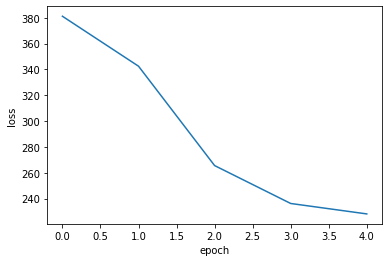

In [52]:
# We can make a plot to observe better
import matplotlib.pyplot as plt

plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Although slow, we can observe that the model works and seems to improve over time.

### Cleaning

In [53]:
# We will clean some variables that will not be used again
train_sample = None
train_sample_y = None
train_sample_len = None
train_sample_X = None
input_seq = None
X_np = None
Y_np = None

## 3.3 Build and Train the PyTorch Model

Once the training script works correctly, we will copy adequately on the train.py file.

A typical training script:

- Loads training data from a specified directory
- Parses any training & model hyperparameters (ex. nodes in a neural network, training epochs, etc.)
- Instantiates a model of your design, with any specified hyperparams
- Trains that model
- Finally, saves the model so that it can be hosted/deployed, later


In [54]:
!pygmentize source/train.py

import argparse
import json
import os
import pickle
import sys
import sagemaker_containers
import pandas as pd
import torch
import torch.optim as optim
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from utils import one_hot_encode

from model import WordOrderer, Decoder, Encoder

def obtain_data(data_dir, namefile, batch_s):
    # Load the training data.
    train_sample = pd.read_csv(os.path.join(data_dir, namefile), header=None, names=None)
    print('Loaded csv')

    train_sample_y = train_sample[train_sample.columns[0:34]]
    train_sample_len = train_sample[train_sample.columns[34]]
    train_sample_X = train_sample[train_sample.columns[34:69]]
    print('Size read from csv -> X: {}, Y: {}, len: {}'.format(train_sample_X.shape, train_sample_len.shape, train_sample_y.shape))

    X_np = train_sample_X.to_numpy(copy=True)
    len_np = train_sample_len.to_numpy(copy=True)
    Y_np = train_sample_y.to_numpy(copy=True)
    print('To 

## 3.4 Create Pytorch Estimator

In [72]:
# import a PyTorch wrapper
from sagemaker.pytorch import PyTorch

# specify an output path
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point = 'train.py',
                    source_dir = 'source',
                    role = role,
                    framework_version = '1.0',
                    train_instance_count = 1,
                    train_instance_type = 'ml.c4.xlarge',
                    output_path = output_path,
                    sagemaker_session = sagemaker_session,
                    hyperparameters = {
                        'input_dim': 34,
                        'output_dim': 27,
                        'hidden_dim': 156,
                        'epochs': 90,
                        'lr': 0.0005,
                    })

As early stopping has been implemented, we try with a large number of epochs.

## 3.5 Train the Estimator

This will take some time, take it easy.

In [73]:
%%time 
# train the estimator on S3 training data
estimator.fit({'train': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-10 21:45:59 Starting - Starting the training job...
2020-08-10 21:46:00 Starting - Launching requested ML instances......
2020-08-10 21:47:06 Starting - Preparing the instances for training......
2020-08-10 21:48:24 Downloading - Downloading input data
2020-08-10 21:48:24 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-08-10 21:48:24,923 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-08-10 21:48:24,926 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-10 21:48:24,938 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-08-10 21:48:24,939 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-08-10 21:48:25,173 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.p

# 4 Prediction with the trained Model

## 4.1 Getting letters back

We need a function that allows obtaining the words back from the padded version to the shorter integer version, and from this integer version to the string version using the dictionaries. This will be done in the following functions.

If the model returns all 0's (in the case it had a bad performance). The word will consist of a dot.

Also, this will be useful if we want to show how the words in the sentence have been jumbled.

In [74]:
def integer2word(number_dict, word, len_word):
    
    word_back = []
    for letter_index, letter in enumerate(word):
        if letter_index < len_word:
            if letter in number_dict:
                word_back.append(number_dict[letter])
            else:
                word_back.append('.')
                        
    return word_back


def integer2sentence(number_dict, data, len_data):
    result = []
    
    perc=0
    idx_w = 0
    for word, len_w in zip(data, len_data):
        if idx_w / len(data) >= perc:
            print('{} / {} words = {}%'.format(idx_w, len(data), np.round(perc*100, decimals = 1)))
            perc = perc+0.1

        converted_word = integer2word(number_dict, word, len_w)

        result.append(converted_word)
        idx_w += 1
        
    return result

In [75]:
# We will use the input training data to check and we will see how the sentence would be seen once jumbled
def join_sentence(sentence):
    list_words = []
    for word in sentence:
        w = ''.join(word)
        list_words.append(w)

    sentence_joined = ' '.join(list_words)
    
    return sentence_joined

In [76]:
# We will use the test dataset preparated, and assume that the sentence is the first 10 words of the file.
test_sample = pd.read_csv(os.path.join(model_dir, 'train.csv'), header=None, names=None, nrows=10)
test_sample_x = test_sample[test_sample.columns[34:69]].to_numpy(copy=True)
test_sample_len = test_sample[test_sample.columns[34]].to_numpy(copy=True)
test_sample_y = test_sample[test_sample.columns[0:34]].to_numpy(copy=True)

# Check one sentence, we will consider 5 consecutive words from the training data as a sentence
input_words = integer2sentence(int2letter, test_sample_x[:,1:], test_sample_len)
output_words = integer2sentence(int2letter, test_sample_y, test_sample_len)

print('{} \n<--> \n{}'.format(join_sentence(input_words), join_sentence(output_words)))

0 / 10 words = 0%
1 / 10 words = 10.0%
2 / 10 words = 20.0%
4 / 10 words = 30.0%
5 / 10 words = 40.0%
6 / 10 words = 50.0%
7 / 10 words = 60.0%
8 / 10 words = 70.0%
9 / 10 words = 80.0%
0 / 10 words = 0%
1 / 10 words = 10.0%
2 / 10 words = 20.0%
4 / 10 words = 30.0%
5 / 10 words = 40.0%
6 / 10 words = 50.0%
7 / 10 words = 60.0%
8 / 10 words = 70.0%
9 / 10 words = 80.0%
taht have wtih tihs just like abuot ulrlnik tehy form 
<--> 
that have with this just like about urllink they from


## 4.2 Predict Function

We will do the same as we did with the training script to check it works first. The input will be the word already transformed into the integers array.

### Predicting a sentence

In order to predict the sentence as a string, we will transform the sentence into its integer jumbled form with the prepare_predict function. And after the prediction, we will have to transform them back with the read_prediction function, as they will expect to receive the same type of data they sended.

In [77]:
def prepare_predict(sentence, dictionary):
    input_data_words = post_to_words(sentence)
    
    print('Converting data')
    integer_sentence, len_sentence = sentence2integer(dictionary, input_data_words)
    print('Jumbling data')
    jumbled_sentence = jumble_data(integer_sentence, len_sentence)
    
    #words with the length previously
    for word, leng in zip(jumbled_sentence, len_sentence):
        word.insert(0, leng)

    return integer_sentence, jumbled_sentence, len_sentence

In [78]:
def read_prediction(prediction, lengths, dictionary):
    return join_sentence(integer2sentence(dictionary, prediction, lengths))

### Function

The words that are less than 4 letters, will be returned as such without passing through the model, as no transformation is applied.

The function will check if the input is a string array or an integer array, and in the case of the string, it will apply the functions necessary to have the adequate type.

In [79]:
def predict(data_input, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    integer_sentence = [] 
    for word in data_input:
        word_batch = [word]

        if len(word) > 3:
            dict_size = 34
            seq_len = 35
            batch_size =1
            test_seq = one_hot_encode(word_batch, dict_size, seq_len, batch_size)
            
            data = torch.from_numpy(test_seq).float().squeeze().to(device)
            # Have the torch as a batch of size 1
            data_batch = data.view(1, np.shape(data)[0], np.shape(data)[1])
            # Make sure to put the model into evaluation mode
            model.eval()

            with torch.no_grad():
                
                output = model.forward(data_batch)
                
                word_integer = []
                for letter in output[0]: #as there's only 1 batch
                    letter_numpy = letter.numpy()
                    max_value_ind = np.argmax(letter_numpy, axis=0)
                    word_integer.append(max_value_ind)
                
        else:
            word_integer = word_batch.copy()
            
        integer_sentence.append(word_integer)
        
    return integer_sentence

In [80]:
int_result = predict(test_sample_x, model)
str_result = read_prediction(int_result, test_sample_len, int2letter)
print('(1st word) Result  -> Ground Truth:')
print(int_result[0])
print('->')
print(test_sample_y[0])
print('\nResulting sentence: {}'.format(str_result))

0 / 10 words = 0%
1 / 10 words = 10.0%
2 / 10 words = 20.0%
4 / 10 words = 30.0%
5 / 10 words = 40.0%
6 / 10 words = 50.0%
7 / 10 words = 60.0%
8 / 10 words = 70.0%
9 / 10 words = 80.0%
(1st word) Result  -> Ground Truth:
[20, 1, 1, 20, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
->
[20  8  1 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0]

Resulting sentence: taat have weth tees jugt leke abuot ulrllik teey form


It seems to work correctly (ignoring the model performance). So on the next step now we will try it with a sentence string.

In [81]:
s = 'A study from Cambridge, has stated that etcetera'

original_s_int, jumbled_s_int, data_len = prepare_predict(s, letter2int)
output_array = predict(jumbled_s_int, model)
output_string = read_prediction(output_array, data_len, int2letter)

print('\nResulting array:', output_array)
print('\nResulting string:', output_string)
print('\nLength original sentence was {}, length of returned sentence is {}'.format(len(s.split(' ')), 
                                                                                    len(output_string.split(' '))))

Converting data
0 / 8 word = 0%
1 / 8 word = 10.0%
2 / 8 word = 20.0%
3 / 8 word = 30.0%
4 / 8 word = 40.0%
5 / 8 word = 50.0%
6 / 8 word = 60.0%
7 / 8 word = 70.0%
Jumbling data
0 / 8 words = 0%
1 / 8 words = 10.0%
2 / 8 words = 20.0%
3 / 8 words = 30.0%
4 / 8 words = 40.0%
5 / 8 words = 50.0%
6 / 8 words = 60.0%
7 / 8 words = 70.0%
0 / 8 words = 0%
1 / 8 words = 10.0%
2 / 8 words = 20.0%
3 / 8 words = 30.0%
4 / 8 words = 40.0%
5 / 8 words = 50.0%
6 / 8 words = 60.0%
7 / 8 words = 70.0%

Resulting array: [[1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], [19, 20, 4, 9, 25, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], [6, 18, 1, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], [3, 1, 13, 7, 18, 2, 9, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], [8, 1, 19, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

Again we can observe that it works fine, the result depend on the model.

## 4.3 Predict Model

Before we can deploy this custom PyTorch model, we have to take one more step: creating a PyTorchModel. This model is responsible for knowing how to execute a specific predict.py script and it is what we'll deploy to create an endpoint.

Also don't forget to copy the predict function into the predict.py file and that there's a utils.py file, which contains the functions necessary to make all the others work correctly.

In [82]:
%%time
# importing PyTorchModel
from sagemaker.pytorch import PyTorchModel

# Create a model from the trained estimator data
# And point to the prediction script
pmodel = PyTorchModel(model_data = estimator.model_data,
                     role = role,
                     framework_version = '1.0',
                     source_dir = 'source',
                     entry_point = 'predict.py',
                    )

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


CPU times: user 16.4 ms, sys: 6 µs, total: 16.5 ms
Wall time: 45.5 ms


### 4.3.1 Deploy trained Model

In [87]:
%%time
# deploy and create a predictor
predictor = pmodel.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Using already existing model: sagemaker-pytorch-2020-08-10-22-10-36-834


-------------!CPU times: user 258 ms, sys: 12.2 ms, total: 270 ms
Wall time: 6min 32s


# 5 Evaluate the Model

Once the model is deployed, we can see how it performs when applied to the test data.

The provided function below takes in a deployed predictor and the sentence and returns two metrics: the accuracy of words which has been fully correctly reconstructed and the accuracy of letters that have been positioned correctly in the sentence.

Also if you want to try it with the predict function written on 4.2, you only have to replace the predictor.predict for a predict.

In [88]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
      
#Helping function
def equalArrays(arr1, arr2):
    equal = True
    for i1, i2 in zip(arr1, arr2):
        if i1!=i2:
            equal = False
    return equal

# code to evaluate the endpoint on test data
def evaluate(predictor, sentence, ground_truth, lengths, verbose=True):
    """ Evaluate a model on a test set given the prediction endpoint."""
    
    input_data = pd.DataFrame(sentence)
    predict_array = predictor.predict(sentence)
#     predict_array = predict(sentence, model)
       
    # Both sentences have to have the same number of words
    if len(sentence) != len(ground_truth):
        print('error in the length obtained')
        return 0
    
    correct_w = 0
    all_results = []
    all_original = []
    for original, result, length in zip(ground_truth, predict_array, lengths):
        if equalArrays(original[:length], result[:length]) and length!=0:
            correct_w += 1
        for lo, lr in zip(original[:length], result[:length]):
            all_results.append(lr)
            all_original.append(lo)
                
            
    accuracy_w = correct_w / len(sentence)
#     accuracy_l = correct_l / num_letters
    acc_l = accuracy_score(all_original, all_results)
    cosine = np.mean(cosine_similarity(predict_array,ground_truth)[0])
    cm = confusion_matrix(all_original, all_results)

    return accuracy_w, acc_l, cm, cosine

We have to read the test.csv file to obtain all the test words.

In [89]:
evaluate_sample = pd.read_csv(os.path.join(cache_dir, 'test.csv'), header=None, names=None, nrows=1)
eval_sample_x = evaluate_sample[evaluate_sample.columns[34:69]].to_numpy(copy=True)
eval_sample_len = evaluate_sample[evaluate_sample.columns[34]].to_numpy(copy=True)

test_data = pd.concat([pd.DataFrame(eval_sample_len), pd.DataFrame(eval_sample_x)], axis=1)
print(test_data)

   0   0   1   2   3   4   5   6   7   8   ...  25  26  27  28  29  30  31  \
0   4   4   5  12  19   5   0   0   0   0  ...   0   0   0   0   0   0   0   

   32  33  34  
0   0   0   0  

[1 rows x 36 columns]


In [90]:
predictor.predict(test_data)

array([[ 4,  5, 12, 19,  5,  5,  5,  5,  5,  5,  5,  5,  5,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1]])

As it gives error if the dataframe is of more than 5000 elements, as it takes to much time to predict, we divide the test set into 4 dataframes of 5000 and predict all of them.

In [91]:
evaluate_sample = pd.read_csv(os.path.join(cache_dir, 'test.csv'), header=None, names=None)

chunk_size = 5000
splits = range(1 * chunk_size, (evaluate_sample.shape[0] // chunk_size + 1) * chunk_size, chunk_size)[:-1]

t_acc_w = []
t_acc_l = []
t_cosine = []
t_cm = np.zeros((26,26))

start = 0
end = chunk_size

for dff in np.split(evaluate_sample, splits, axis=0):
    eval_sample_x = dff[dff.columns[34:69]].to_numpy(copy=True)
    eval_sample_len = dff[dff.columns[34]].to_numpy(copy=True)
    eval_sample_y = dff[dff.columns[0:34]].to_numpy(copy=True)

    acc_w, acc_l, cm, cosine = evaluate(predictor, eval_sample_x, eval_sample_y, eval_sample_len)

    print('For elements {}-{}, {}'.format(start, end, dff.shape))
    print('Word Accuracy: {}'.format(acc_w))
    print('Letter Accuracy: {}'.format(acc_l))
    print('Mean Cosine Distance: {}'.format(cosine))
    t_acc_w.append(acc_w)
    t_acc_l.append(acc_l)
    t_cosine.append(cosine)
    t_cm += cm
    start += chunk_size
    end += chunk_size
    
print('\nTotal results:')
print('Word Accuracy: {}'.format(np.sum(t_acc_w)/len(t_acc_w)))
print('Letter Accuracy: {}'.format(np.sum(t_acc_l)/len(t_acc_l)))
print('Mean Cosine Distance: {}'.format(np.sum(t_cosine)/len(t_cosine)))
    

For elements 0-5000, (5000, 69)
Word Accuracy: 0.299
Letter Accuracy: 0.6254250026842275
Mean Cosine Distance: 0.5919297003612474
For elements 5000-10000, (5000, 69)
Word Accuracy: 0.302
Letter Accuracy: 0.6309523809523809
Mean Cosine Distance: 0.5361515785231741
For elements 10000-15000, (5000, 69)
Word Accuracy: 0.3024
Letter Accuracy: 0.6309820493372341
Mean Cosine Distance: 0.46211771126858187
For elements 15000-20000, (5000, 69)
Word Accuracy: 0.3058
Letter Accuracy: 0.6323941637317617
Mean Cosine Distance: 0.45579107400861474

Total results:
Word Accuracy: 0.3023
Letter Accuracy: 0.629938399176401
Mean Cosine Distance: 0.5114975160404045


We observe that it reconstructs almost 1 out of 3 words right and have an accuracy of 63% for the letters, which is pretty good! In the next section we will observe its results and evaluate them ourselves.

But first, remember to delete the endpoint.

[Text(30.5, 0.5, 'Ground Truth'), Text(0.5, 12.5, 'Predicted')]

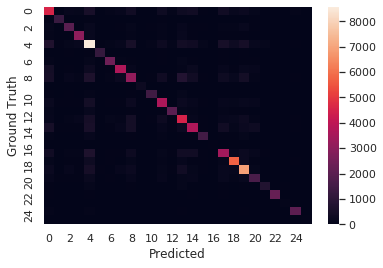

In [92]:
import seaborn as sns
sns.set()
ax = sns.heatmap(t_cm)
ax.set(xlabel="Predicted", ylabel = "Ground Truth")

In [93]:
boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)

{'ResponseMetadata': {'RequestId': 'c6d02813-d1a7-4f5a-9401-2a097f88313f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c6d02813-d1a7-4f5a-9401-2a097f88313f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 10 Aug 2020 22:22:53 GMT'},
  'RetryAttempts': 0}}

# 6 Use Model for Web App

Although maybe its performance is not the best, our model is working, so it's time to create some custom inference code so that we can send the model a review which has not been processed and have it determine the sentiment of the review.

As we saw above, by default the estimator which we created, when deployed, will use the entry script and directory which we provided when creating the model. However, since we now wish to accept a string as input and our model expects a processed review, we need to write some custom inference code (the predict file). For the rest of the files, we can copy the ones from the source directory to the serve directory and provide them to the SageMaker inference container to deploy a Pytorch model.

For setting up everything I will follow the steps explained by Nadim Kawwa at https://github.com/NadimKawwa/rnn_sentiment_analysis/blob/master/SageMaker%20Project.ipynb, as they are well explained, understanable and concise.

## 6.1 Deploy for Web App

Now in the serve directory, the predict function will accept a text input and return a text too.

In [94]:
!pygmentize serve/predict.py

import argparse
import os
import sys
import pandas as pd
import numpy as np
import pickle
import sagemaker_containers

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F

from sklearn.utils import shuffle

# import model
from model import WordOrderer, Encoder, Decoder
from utils import join_sentence, integer2sentence, one_hot_encode, prepare_predict, read_prediction

def model_fn(model_dir):
    print("Loading model.")

    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder = Encoder(model_info['input_dim'], model_info['hidden_dim'])
    decoder = Decoder(model_info['input_dim'], model_info['output_dim'], model_info['hidden_dim'])
    model = WordOrderer(encoder, decoder).to(device

In [95]:
from sagemaker.predictor import RealTimePredictor

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='0.4.0',
                     entry_point='predict.py',
                     source_dir='serve',
                     predictor_cls=StringPredictor)
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------!

In [96]:
predictor.endpoint

'sagemaker-pytorch-2020-08-10-22-22-57-688'

## 6.2 Setting up lambda function

The first thing we are going to do is set up a Lambda function. This Lambda function will be executed whenever our public API has data sent to it. When it is executed it will receive the data, perform any sort of processing that is required, send the data (the review) to the SageMaker endpoint we've created and then return the result.

### Part A: Create an IAM Role for the Lambda function

Since we want the Lambda function to call a SageMaker endpoint, we need to make sure that it has permission to do so. To do this, we will construct a role that we can later give the Lambda function.

Using the AWS Console, navigate to the IAM page and click on Roles. Then, click on Create role. Make sure that the AWS service is the type of trusted entity selected and choose Lambda as the service that will use this role, then click Next: Permissions.

In the search box type sagemaker and select the check box next to the AmazonSageMakerFullAccess policy. Then, click on Next: Review.

Lastly, give this role a name. Make sure you use a name that you will remember later on, for example LambdaSageMakerRole. Then, click on Create role.

### Part B: Create a Lambda function

Now it is time to actually create the Lambda function.

Using the AWS Console, navigate to the AWS Lambda page and click on Create a function. When you get to the next page, make sure that Author from scratch is selected. Now, name your Lambda function, using a name that you will remember later on. Make sure that the Python 3.6 runtime is selected and then choose the role that you created in the previous part. Then, click on Create Function.

On the next page you will see some information about the Lambda function you've just created. If you scroll down you should see an editor in which you can write the code that will be executed when your Lambda function is triggered. In this project, we will use the code below.

In [ ]:
import boto3

def lambda_handler(event, context):

    # The SageMaker runtime is what allows us to invoke the endpoint that we've created.
    runtime = boto3.Session().client('sagemaker-runtime')

    # Now we use the SageMaker runtime to invoke our endpoint, sending the review we were given
    response = runtime.invoke_endpoint(EndpointName = '**ENDPOINT_HERE',    # The name of the endpoint we created
                                       ContentType = 'text/plain',                 # The data format that is expected
                                       Body = event['body'])                       # The actual review

    # The response is an HTTP response whose body contains the result of our inference
    result = response['Body'].read().decode('utf-8')

    return {
        'statusCode' : 200,
        'headers' : { 'Content-Type' : 'text/plain', 'Access-Control-Allow-Origin' : '*' },
        'body' : result
    }

Once you have copy and pasted the code above into the Lambda code editor, replace the **ENDPOINT NAME HERE** portion with the name of the endpoint that we deployed earlier. You can determine the name of the endpoint using the code cell below.

And once you have added the endpoint name to the Lambda function, click on Save. Your Lambda function is now up and running. Next we need to create a way for our web app to execute the Lambda function.

## 6.3 Setting Up API Gateway

Now that our Lambda function is set up, it is time to create a new API using API Gateway that will trigger the Lambda function we have just created.

Using AWS Console, navigate to Amazon API Gateway and then click on Get started.

On the next page, make sure that New API is selected and give the new api a name. Then, click on Create API.

Now we have created an API, however it doesn't currently do anything. What we want it to do is to trigger the Lambda function that we created earlier.

Select the Actions dropdown menu and click Create Method. A new blank method will be created, select its dropdown menu and select POST, then click on the check mark beside it.

For the integration point, make sure that Lambda Function is selected and click on the Use Lambda Proxy integration. This option makes sure that the data that is sent to the API is then sent directly to the Lambda function with no processing. It also means that the return value must be a proper response object as it will also not be processed by API Gateway.

Type the name of the Lambda function you created earlier into the Lambda Function text entry box and then click on Save. Click on OK in the pop-up box that then appears, giving permission to API Gateway to invoke the Lambda function you created.

The last step in creating the API Gateway is to select the Actions dropdown and click on Deploy API. You will need to create a new Deployment stage and name it anything you like, for example prod.

You have now successfully set up a public API to access your SageMaker model. Make sure to copy or write down the URL provided to invoke your newly created public API as this will be needed in the next step. This URL can be found at the top of the page, highlighted in blue next to the text Invoke URL.

## 6.4 Deploying our web app

Now that we have a publicly available API, we can start using it in a web app with the static HTML file which will make use of the public api you created earlier.

In the website folder there should be a file called index.html. Download the file to your computer and open that file up in a text editor of your choice. You should replace the value of the **action = ...** line on the code with the url that you wrote down in the last step and then save the file.

Now, if you open index.html on your local computer, your browser will behave as a local web server and you can use the provided site to interact with your SageMaker model.

If you'd like to go further, you can host this html file anywhere you'd like, for example using github or hosting a static site on Amazon's S3.

## 6.5 Web results

After finally deploying the web, we can try it with some sentences and see what it returns:
    
- this isn't an example sentence -> **this inst an elwalpe stanenne**

- Despite the apparences, she stod among the best -> **detiese the acteeeeens she stod acnog the best**

- You have to be more careful and read between the lines -> **you have to be more courfel and read betewen the lenns**

- Did you know that, along with gorgeous architecture, it's home to the largest tamale? -> **did you know taat annig watt gugslues acerrctrhice ins hume to the laggest tallle*

This results coincide with the numerical results obtained earlier, but you can try twisting the model parameters and see if yours obtain better results.

**With this we have finally completed this project notebook**

# 7 Delet the endpoint & Final cleanup

In [97]:
# delete the predictor endpoint 
boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)

{'ResponseMetadata': {'RequestId': '55f408ee-b35d-4625-aec6-1cb9ecc664b5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '55f408ee-b35d-4625-aec6-1cb9ecc664b5',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 10 Aug 2020 22:38:10 GMT'},
  'RetryAttempts': 0}}

Remember to always shut down your endpoint if you are no longer using it. You are charged for the length of time that the endpoint is running so if you forget and leave it on you could end up with an unexpectedly large bill. Also look to clean the S3 bucket, the models, endpoints configurations, lambda functions, etc.